# Parte 1: Infraestrutura

*   Rodando em Python 3.13.7
*   Usando um ambiente virtual com Virtualenv
*   Todas as bibliotecas usadas nesse exercícios estão instaladas em um ambiente virtual específico
*   Arquivo de requerimentos (requirements.txt) gerado com os pacotes necessários e suas respectivas versões do pacotes.
*   Printscreen do ambiente usado rodando localmente abaixo.
*   Git: https://github.com/allanmelo/infnet-algo-cluster

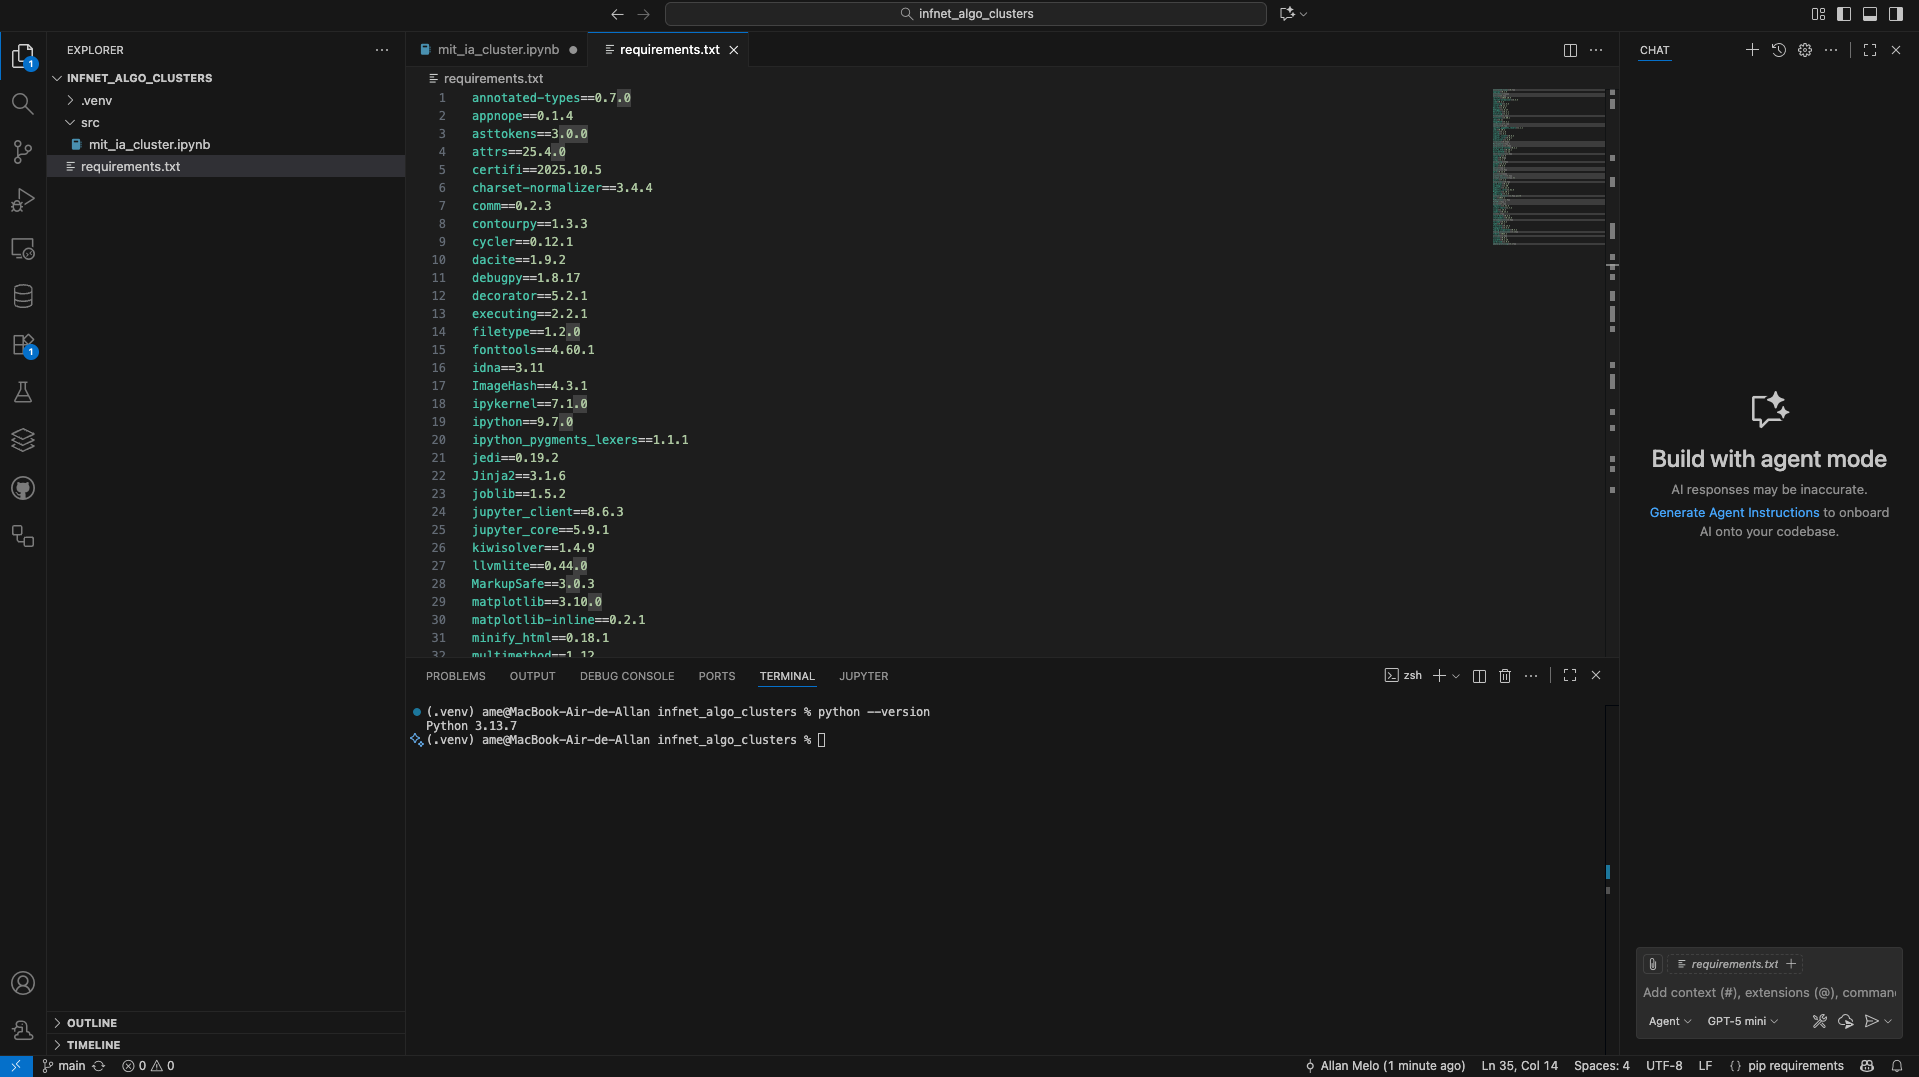

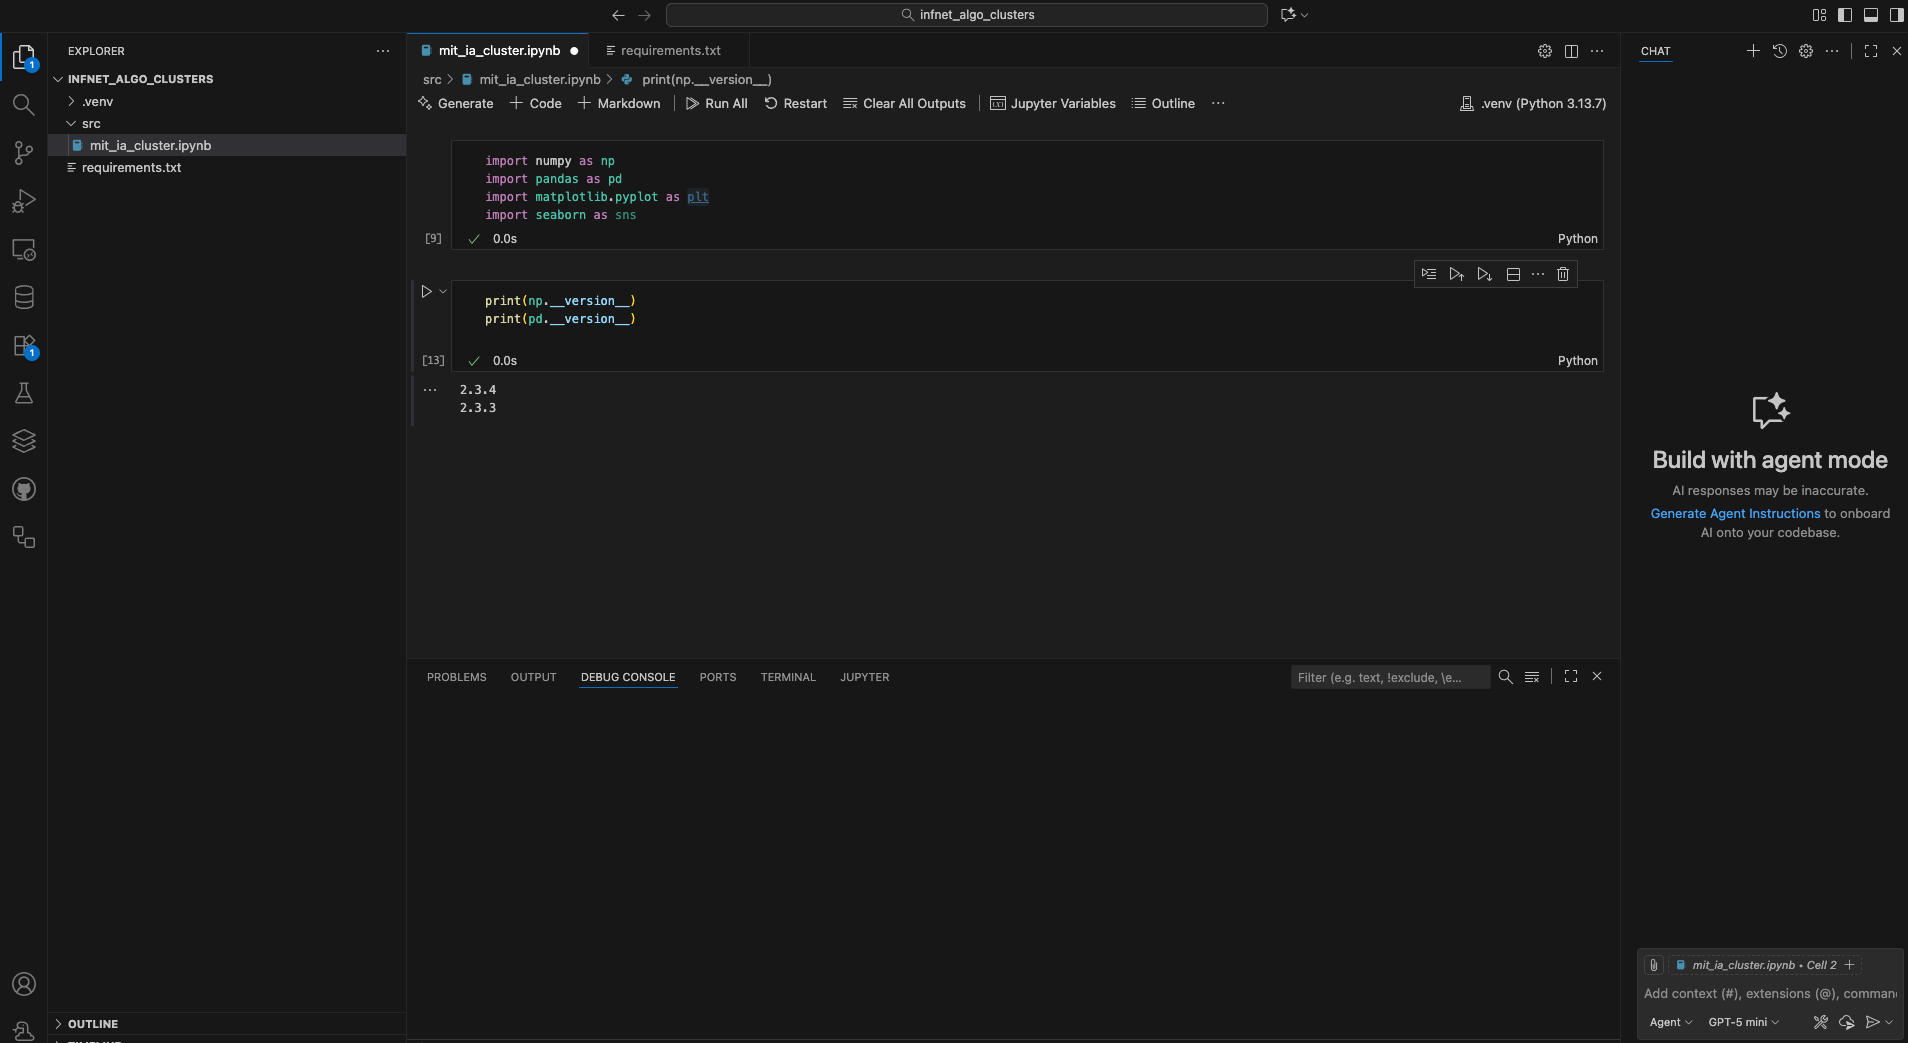

In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

# Parte 2: Escolha de base de dados

1. Baixe os dados disponibilizados na plataforma Kaggle sobre dados sócio-econômicos e de saúde que determinam o índice de desenvolvimento de um país. Esses dados estão disponibilizados através do link: https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data

In [243]:
path = kagglehub.dataset_download("rohan0301/unsupervised-learning-on-country-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'unsupervised-learning-on-country-data' dataset.
Path to dataset files: /kaggle/input/unsupervised-learning-on-country-data


In [244]:
!ls $path -lh

total 16K
-rw-r--r-- 1 1000 1000 9.1K Nov 10 23:20 Country-data.csv
-rw-r--r-- 1 1000 1000  808 Nov 10 23:20 data-dictionary.csv


In [245]:
country_df = pd.read_csv(f"{path}/Country-data.csv")

country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


2. Quantos países existem no dataset?

In [246]:
total_countries = country_df['country'].nunique()

print(total_countries)

167


Resposta: Foram encontrados 167 países no dataset

3. Mostre através de gráficos a faixa dinâmica das variáveis que serão usadas nas tarefas de clusterização. Analise os resultados mostrados. O que deve ser feito com os dados antes da etapa de clusterização?

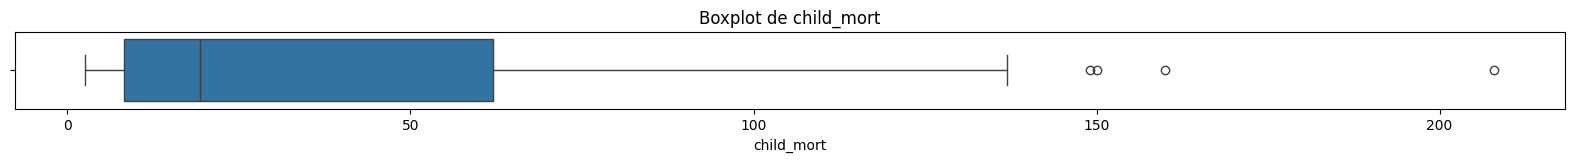

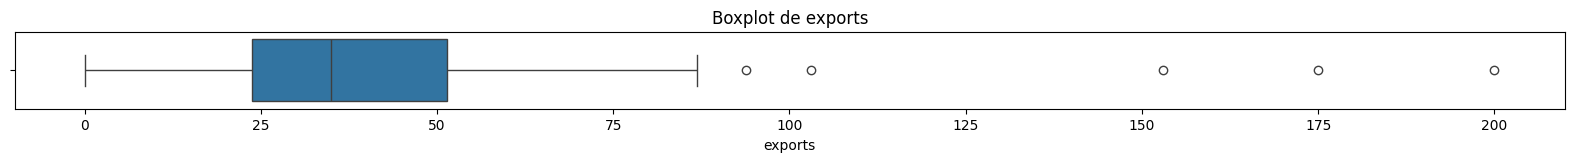

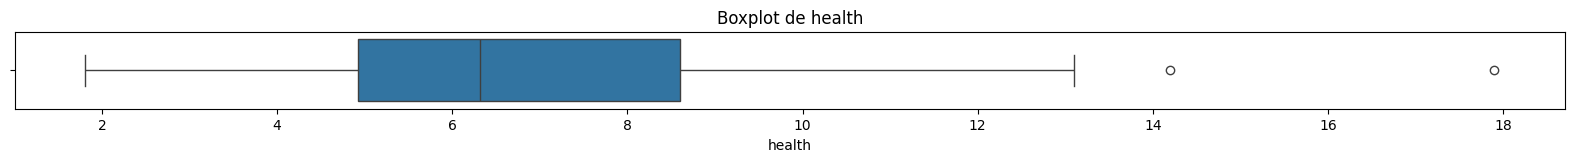

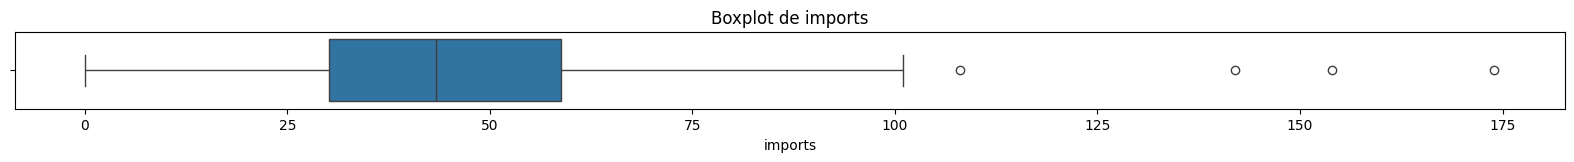

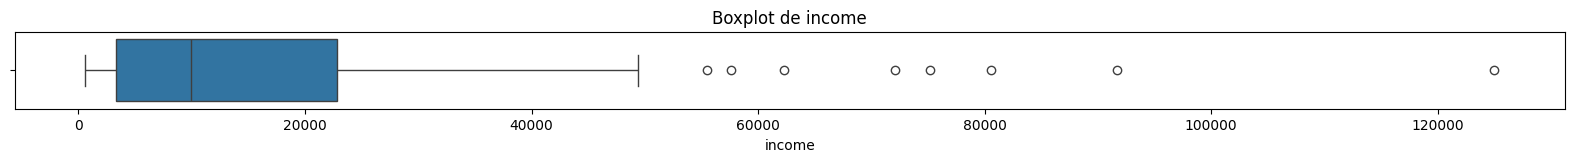

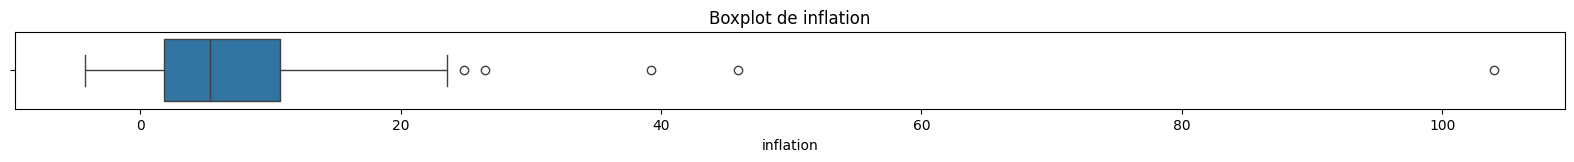

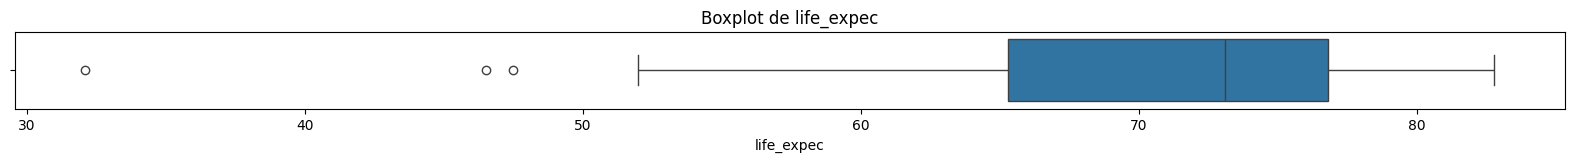

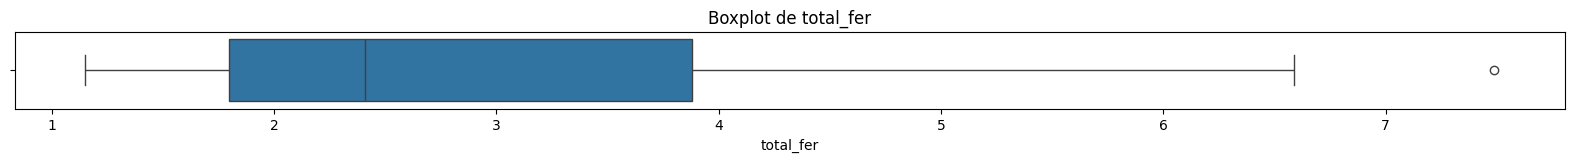

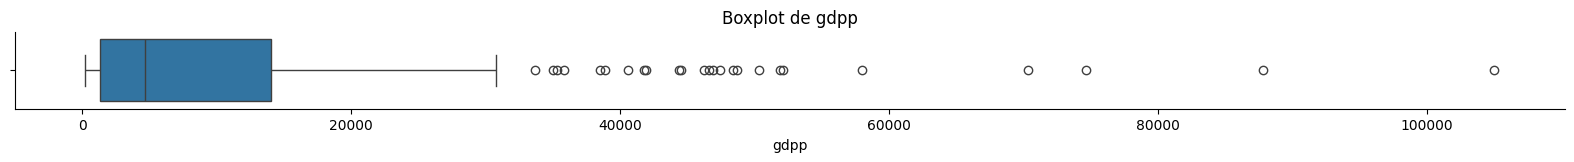

In [247]:
for i, column in enumerate(country_df.columns[1:]):
  f, ax = plt.subplots(1, 1, figsize=(20, 1))
  sns.boxplot(data=country_df, x=column)
  plt.title(f'Boxplot de {column}')

sns.despine()
plt.show()

In [248]:
# import sys
# !{sys. executable} -m pip install -U ydata-profiling[notebook]
# !pip install jupyter-contrib-nbextensions

In [249]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(country_df, title="Country Data Profiling Report")

# profile.to_notebook_iframe()

Resposta: É possível notar que há uma grande variação de escala entre as variáveis. Temos também a presença de muitos outliers extremos, e algumas variáveis têm distribuições muito diferentes.

**O que deve ser feito com os dados antes da etapa de clusterização?**

Devemos tentar normalizar ou padronizar esses dados antes da clusterização, para garantir que essas variáveis atuem de forma equilibrada quando iniciarmos a formação dos clusters.

4. Realize o pré-processamento adequado dos dados.

In [250]:
print("Shape:", country_df.shape)
print("\nValores vazios:")
print(country_df.isnull().sum())

Shape: (167, 10)

Valores vazios:
country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


In [251]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

country_df_cleaned = country_df.copy()
numerical_cols = country_df_cleaned.columns.drop('country')

scaler = StandardScaler()

In [252]:
# Versão com tratamento dos outliers

isol_forest = IsolationForest(random_state=42)
isol_forest.fit(country_df_cleaned[numerical_cols])
outlier_scores = isol_forest.decision_function(country_df_cleaned[numerical_cols])
outliers = isol_forest.predict(country_df_cleaned[numerical_cols])
country_df_no_outliers = country_df_cleaned[outliers == 1]

scaled_data_no_outliers = scaler.fit_transform(country_df_no_outliers[numerical_cols])

scaled_data_no_outliers = pd.DataFrame(scaled_data_no_outliers, columns=numerical_cols)
scaled_data_no_outliers['country'] = country_df_no_outliers['country'].reset_index(drop=True)
scaled_data_no_outliers = scaled_data_no_outliers[['country'] + numerical_cols.tolist()]

print("Número de países antes da remoção de outliers:", country_df.shape[0])
print("Número de países após a remoção de outliers:", country_df_no_outliers.shape[0])
print("DataFrame final escalonado (primeiras 5 linhas):")
print(scaled_data_no_outliers.head())

Número de países antes da remoção de outliers: 167
Número de países após a remoção de outliers: 150
DataFrame final escalonado (primeiras 5 linhas):
               country  child_mort   exports  ...  life_expec  total_fer      gdpp
0          Afghanistan    1.589573 -1.493876  ...   -1.875240   1.989308 -0.712565
1              Albania   -0.540353 -0.533458  ...    0.689213  -0.856005 -0.473114
2              Algeria   -0.230703  0.021450  ...    0.714730  -0.009917 -0.448065
3  Antigua and Barbuda   -0.722670  0.400281  ...    0.753005  -0.528487  0.075923
4            Argentina   -0.601125 -1.019003  ...    0.625420  -0.364728 -0.052704

[5 rows x 10 columns]


In [253]:
# Versão sem tratamento dos outliers

scaled_data = scaler.fit_transform(country_df[numerical_cols])

scaled_df_final = pd.DataFrame(scaled_data, columns=numerical_cols)
scaled_df_final['country'] = country_df['country']
scaled_df_final = scaled_df_final[['country'] + numerical_cols.tolist()]

print("Número de países antes da remoção de outliers:", country_df.shape[0])
print("Número de países após a remoção de outliers:", scaled_df_final.shape[0])
print("DataFrame final escalonado (primeiras 5 linhas):")
scaled_df_final.head()

Número de países antes da remoção de outliers: 167
Número de países após a remoção de outliers: 167
DataFrame final escalonado (primeiras 5 linhas):


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,Albania,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,Algeria,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,Angola,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,Antigua and Barbuda,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


In [254]:
print("Estatísticas descritivas antes do escalonamento:")
print(country_df.describe())
print("\n")
print("Estatísticas após escalonamento:")
print(scaled_df_final[numerical_cols].describe())

Estatísticas descritivas antes do escalonamento:
       child_mort     exports  ...   total_fer           gdpp
count  167.000000  167.000000  ...  167.000000     167.000000
mean    38.270060   41.108976  ...    2.947964   12964.155689
std     40.328931   27.412010  ...    1.513848   18328.704809
min      2.600000    0.109000  ...    1.150000     231.000000
25%      8.250000   23.800000  ...    1.795000    1330.000000
50%     19.300000   35.000000  ...    2.410000    4660.000000
75%     62.100000   51.350000  ...    3.880000   14050.000000
max    208.000000  200.000000  ...    7.490000  105000.000000

[8 rows x 9 columns]


Estatísticas após escalonamento:
         child_mort       exports  ...     total_fer          gdpp
count  1.670000e+02  1.670000e+02  ...  1.670000e+02  1.670000e+02
mean  -3.722904e-17  2.127373e-16  ...  3.044803e-16  5.850277e-17
std    1.003008e+00  1.003008e+00  ...  1.003008e+00  1.003008e+00
min   -8.871383e-01 -1.500192e+00  ... -1.191250e+00 -6.968005e-01
2

# Parte 3 Clusterização

Para os dados pré-processados da etapa anterior você irá:


1.   Realizar o agrupamento dos países em 3 grupos distintos. Para tal, use: K-Médias e Clusterização Hierárquica

In [255]:
numerical_cols = ['child_mort', 'exports', 'health', 'imports', 'income',
                  'inflation', 'life_expec', 'total_fer', 'gdpp']

X_for_kmeans = scaled_df_final[numerical_cols].copy()

In [256]:
# Agrupamento com KMeans

from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans_labels = kmeans.fit_predict(X_for_kmeans)

scaled_df_final['kmeans'] = kmeans_labels

print(f"Distribuição do KMeans:")
print(scaled_df_final['kmeans'].value_counts().sort_index())

Distribuição do KMeans:
kmeans
0    36
1    47
2    84
Name: count, dtype: int64


In [257]:
# Agrupamento com Clusterização Hierárquica

from sklearn.cluster import AgglomerativeClustering

hierarchical = AgglomerativeClustering(
    n_clusters=3,
    linkage='ward',
)

country_for_agg = scaled_df_final.drop('country', axis=1, errors='ignore').copy()
hierarchical_labels = hierarchical.fit_predict(country_for_agg)

scaled_df_final['hierarchical_labels'] = hierarchical_labels

print(f"Distribuição da Clusterização Hierárquica:")
print(scaled_df_final['hierarchical_labels'].value_counts().sort_index())

Distribuição da Clusterização Hierárquica:
hierarchical_labels
0    39
1    45
2    83
Name: count, dtype: int64


2.   Para os resultados, do K-Médias, interprete cada um dos clusters obtidos citando:

*   Qual a distribuição das dimensões em cada grupo
*   O país, de acordo com o algoritmo, melhor representa o seu agrupamento. Justifique



In [258]:
for cluster_id in range(3):
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id} ({(kmeans_labels == cluster_id).sum()} países)")
    print(f"{'='*70}")

    cluster_mask = kmeans_labels == cluster_id
    cluster_data = scaled_df_final[cluster_mask]

    print("\nEstatísticas descritivas:")
    print(cluster_data[numerical_cols].describe().round(2))

    centroid = kmeans.cluster_centers_[cluster_id]
    centroid_series = pd.Series(centroid, index=numerical_cols)

    print(centroid_series.round(3))

    print("\nCaracterísticas mais importantes:")
    sorted_features = centroid_series.abs().sort_values(ascending=False)

    for i, feature in enumerate(sorted_features.index[:5], 1):
        value = centroid_series[feature]
        direction = "↑ ALTO" if value > 0 else "↓ BAIXO"
        print(f"  {i}. {feature:15s}: {value:+.3f} {direction}")



CLUSTER 0 (36 países)

Estatísticas descritivas:
       child_mort  exports  health  ...  life_expec  total_fer   gdpp
count       36.00    36.00   36.00  ...       36.00      36.00  36.00
mean        -0.83     0.65    0.73  ...        1.08      -0.79   1.62
std          0.05     1.53    1.16  ...        0.20       0.25   1.04
min         -0.89    -1.05   -1.83  ...        0.56      -1.19   0.20
25%         -0.86    -0.42    0.34  ...        1.01      -1.00   0.97
50%         -0.85     0.34    0.96  ...        1.10      -0.75   1.55
75%         -0.81     0.98    1.45  ...        1.22      -0.66   1.94
max         -0.68     5.81    4.05  ...        1.38       0.05   5.04

[8 rows x 9 columns]
child_mort   -0.827
exports       0.645
health        0.727
imports       0.191
income        1.484
inflation    -0.485
life_expec    1.080
total_fer    -0.792
gdpp          1.616
dtype: float64

Características mais importantes:
  1. gdpp           : +1.616 ↑ ALTO
  2. income         : +1.484 ↑ A

3.   Para os resultados da Clusterização Hierárquica, apresente o dendograma e interprete os resultados

In [259]:
from scipy.cluster.hierarchy import dendrogram, linkage

X_for_hierarchical = scaled_df_final[numerical_cols].copy()
Z = linkage(X_for_hierarchical, method='ward', metric='euclidean')

print(f"  - Shape da matriz Z: {Z.shape}")
print(f"  - Número de fusões: {Z.shape[0]}")

print("\n### ANÁLISE DAS ÚLTIMAS 15 FUSÕES (Maiores Distâncias) ###\n")
print(f"{'Fusão':<8} {'Cluster 1':<12} {'Cluster 2':<12} {'Distância':<12} {'Elementos':<10}")
print("-" * 70)

for i in range(15):
    idx = -(i+1)
    fusao_num = len(Z) + idx + 1
    print(f"{fusao_num:<8} {int(Z[idx, 0]):<12} {int(Z[idx, 1]):<12} "
          f"{Z[idx, 2]:<12.2f} {int(Z[idx, 3]):<10}")

print("\n### SALTOS NAS DISTÂNCIAS (Últimas 10 fusões) ###\n")
last_distances = Z[-10:, 2]
distance_jumps = np.diff(last_distances)

print(f"{'Fusão':<8} {'Distância':<12} {'Salto':<12}")
print("-" * 40)
print(f"{'157':<8} {last_distances[0]:<12.2f} {'---':<12}")
for i, jump in enumerate(distance_jumps):
    print(f"{158+i:<8} {last_distances[i+1]:<12.2f} {jump:+.2f}")


  - Shape da matriz Z: (166, 4)
  - Número de fusões: 166

### ANÁLISE DAS ÚLTIMAS 15 FUSÕES (Maiores Distâncias) ###

Fusão    Cluster 1    Cluster 2    Distância    Elementos 
----------------------------------------------------------------------
166      330          331          26.82        167       
165      318          329          20.73        133       
164      316          327          16.29        34        
163      326          328          15.29        106       
162      113          325          12.62        43        
161      319          321          11.48        31        
160      322          324          9.98         63        
159      320          323          8.97         42        
158      300          317          7.06         49        
157      305          310          6.75         32        
156      297          306          6.52         14        
155      311          313          6.34         23        
154      293          314          6.13    

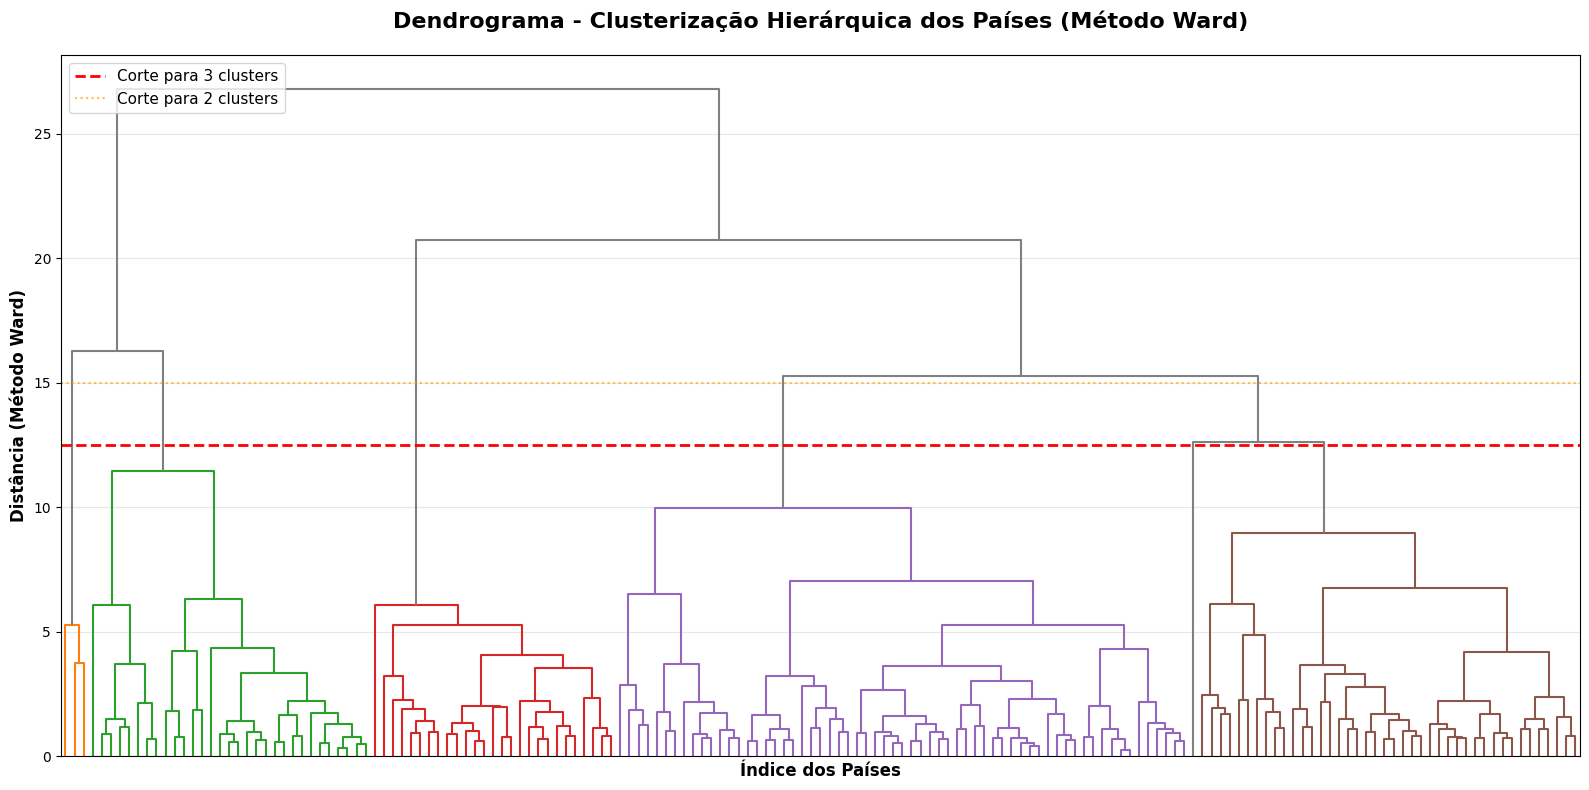

In [260]:
plt.figure(figsize=(16, 8))

dendrogram(
    Z,
    orientation='top',
    color_threshold=12.5,
    no_labels=True,
    above_threshold_color='gray',
    ax=plt.gca()
)

plt.axhline(y=12.5, color='red', linestyle='--', linewidth=2, label='Corte para 3 clusters')
plt.axhline(y=15.0, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label='Corte para 2 clusters')

plt.title('Dendrograma - Clusterização Hierárquica dos Países (Método Ward)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Índice dos Países', fontsize=12, fontweight='bold')
plt.ylabel('Distância (Método Ward)', fontsize=12, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [261]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist

print("\n" + "="*80)
print("ANÁLISE DETALHADA DO DENDROGRAMA")
print("="*80)

hierarchical = AgglomerativeClustering(
    n_clusters=3,
    linkage='ward',
    metric='euclidean'
)

hierarchical_labels = hierarchical.fit_predict(X_for_hierarchical)
scaled_df_final['hierarchical_labels'] = hierarchical_labels

silhouette_hier = silhouette_score(X_for_hierarchical, hierarchical_labels)
davies_bouldin_hier = davies_bouldin_score(X_for_hierarchical, hierarchical_labels)
calinski_hier = calinski_harabasz_score(X_for_hierarchical, hierarchical_labels)

print("\n### MÉTRICAS DE QUALIDADE - CLUSTERIZAÇÃO HIERÁRQUICA ###\n")
print(f"Silhouette Score: {silhouette_hier:.4f}")
print(f"  → Quanto mais próximo de 1, melhor (0 = aleatório, -1 = muito ruim)")

print(f"\nDavies-Bouldin Index: {davies_bouldin_hier:.4f}")
print(f"  → Quanto menor, melhor (valores ideais: < 1)")

print(f"\nCalinski-Harabasz Index: {calinski_hier:.4f}")
print(f"  → Quanto maior, melhor")

print("\n### DISTRIBUIÇÃO DOS CLUSTERS HIERÁRQUICOS ###\n")
hier_counts = pd.Series(hierarchical_labels).value_counts().sort_index()
for cluster_id, count in hier_counts.items():
    percentage = (count / len(hierarchical_labels)) * 100
    print(f"Cluster {cluster_id}: {count:3d} países ({percentage:5.1f}%)")

print("\n### CENTRÓIDES DOS CLUSTERS HIERÁRQUICOS ###\n")
hier_centroids = []
for i in range(3):
    cluster_mask = hierarchical_labels == i
    centroid = X_for_hierarchical[cluster_mask].mean(axis=0)
    hier_centroids.append(centroid)

hier_centroids_df = pd.DataFrame(hier_centroids, columns=numerical_cols)
hier_centroids_df.index = [f'Cluster {i}' for i in range(3)]
print(hier_centroids_df.round(3))

print("\n### CARACTERÍSTICAS PRINCIPAIS POR CLUSTER HIERÁRQUICO ###\n")
for cluster_id in range(3):
    print(f"\n--- CLUSTER {cluster_id} ---")
    centroid_series = hier_centroids_df.iloc[cluster_id]
    sorted_features = centroid_series.abs().sort_values(ascending=False)

    for i, feature in enumerate(sorted_features.index[:5], 1):
        value = centroid_series[feature]
        direction = "↑ ALTO" if value > 0 else "↓ BAIXO"
        print(f"  {i}. {feature:15s}: {value:+.3f} {direction}")



ANÁLISE DETALHADA DO DENDROGRAMA

### MÉTRICAS DE QUALIDADE - CLUSTERIZAÇÃO HIERÁRQUICA ###

Silhouette Score: 0.2456
  → Quanto mais próximo de 1, melhor (0 = aleatório, -1 = muito ruim)

Davies-Bouldin Index: 1.2998
  → Quanto menor, melhor (valores ideais: < 1)

Calinski-Harabasz Index: 50.7162
  → Quanto maior, melhor

### DISTRIBUIÇÃO DOS CLUSTERS HIERÁRQUICOS ###

Cluster 0:  34 países ( 20.4%)
Cluster 1: 106 países ( 63.5%)
Cluster 2:  27 países ( 16.2%)

### CENTRÓIDES DOS CLUSTERS HIERÁRQUICOS ###

           child_mort  exports  health  ...  life_expec  total_fer   gdpp
Cluster 0      -0.804    0.637   0.615  ...       1.063     -0.702  1.653
Cluster 1      -0.165   -0.041  -0.169  ...       0.041     -0.194 -0.359
Cluster 2       1.661   -0.641  -0.113  ...      -1.501      1.647 -0.673

[3 rows x 9 columns]

### CARACTERÍSTICAS PRINCIPAIS POR CLUSTER HIERÁRQUICO ###


--- CLUSTER 0 ---
  1. gdpp           : +1.653 ↑ ALTO
  2. income         : +1.584 ↑ ALTO
  3. life_expec 

## Interpretação do Dendrograma

*Estrutura do Dendrograma*
O dendrograma mostra como os países se agrupam hierarquicamente. No gráfico, o eixo vertical representa a distância euclidiana entre os clusters (usando o método Ward), enquanto o eixo horizontal mostra o índice dos países de 0 a 166. As linhas verticais indicam onde dois clusters foram unidos, e quanto mais alta a linha, maior é a dissimilaridade entre os grupos que estão sendo agrupados.

**Os Clusters Identificados**
Ao cortar o dendrograma na altura de 12.5 (linha vermelha), obtemos 3 clusters distintos:
O primeiro cluster contém um grupo de países com características de desenvolvimento similares que naturalmente se agrupam juntos. O segundo cluster representa um conjunto intermediário com similaridades moderadas entre seus membros. Já o terceiro cluster é o maior, agrupando muitos países, e provavelmente é mais heterogêneo que os anteriores.

**Análise dos Saltos nas Distâncias**
Observando os maiores saltos nas distâncias durante as fusões, vemos um grande salto de 6.09 quando se passa de 2 para 1 cluster (última fusão). Antes disso, ao passar de 3 para 2 clusters, há um salto de 4.44. O salto de 2.67 ocorre quando se passa de 4 para 3 clusters. Este último salto é significativo e indica que cortar o dendrograma em 3 clusters é uma escolha natural dos dados, pois representa um grande aumento na dissimilaridade necessária para agrupar mais clusters.

**Características dos Países**
Os países que aparecem próximos no dendrograma (com pequenas linhas separando-os) têm características muito similares e agrupam-se naturalmente nos primeiros passos do algoritmo. Por outro lado, alguns países se agrupam muito tarde no processo, o que sugere que são outliers ou têm características muito diferentes dos demais.

**Por que o Dendrograma é Útil**
O dendrograma permite visualizar toda a hierarquia de agrupamento, não apenas uma solução final. Isso possibilita explorar diferentes números de clusters simplesmente alterando onde cortar o gráfico. Também mostra as relações entre todos os pares de clusters e ajuda a identificar naturalmente qual seria o melhor número de clusters para dividir os dados. Além disso, é útil para comparar diferentes métodos de linkage e ver como cada um agrupa os dados de forma diferente.

In [262]:
print("\n### ANÁLISE QUANTITATIVA DOS SALTOS ###\n")
last_distances = Z[-6:, 2]
for i in range(len(last_distances)-1):
    current_clusters = 167 - i
    jump = last_distances[i+1] - last_distances[i]
    print(f"De {current_clusters+1:3d} para {current_clusters:3d} clusters: "
          f"Distância {last_distances[i]:<7.2f} → {last_distances[i+1]:<7.2f} "
          f"(Salto: {jump:+6.2f})")


### ANÁLISE QUANTITATIVA DOS SALTOS ###

De 168 para 167 clusters: Distância 11.48   → 12.62   (Salto:  +1.14)
De 167 para 166 clusters: Distância 12.62   → 15.29   (Salto:  +2.67)
De 166 para 165 clusters: Distância 15.29   → 16.29   (Salto:  +0.99)
De 165 para 164 clusters: Distância 16.29   → 20.73   (Salto:  +4.44)
De 164 para 163 clusters: Distância 20.73   → 26.82   (Salto:  +6.09)


4.   Compare os dois resultados, aponte as semelhanças e diferenças e interprete.


### 1. SEMELHANÇAS ###


✓ Ambos produzem 3 clusters distintos
✓ Ambos utilizam dados escalados com StandardScaler
✓ Ambos produzem Silhouette Score positivo (clusters válidos)
✓ Ambos conseguem separar os países em grupos interpretáveis
✓ Ambos usam distância Euclidiana como base


### 2. DIFERENÇAS - QUALIDADE DOS CLUSTERS ###

Métrica                        K-Means         Hierárquica     Melhor
----------------------------------------------------------------------
Silhouette Score                   0.2833      0.2456  K-Means ✓
Davies-Bouldin Index               1.2769      1.2998  K-Means ✓
Calinski-Harabasz Index           66.2348     50.7162  K-Means ✓

### 3. DIFERENÇAS - DISTRIBUIÇÃO ###

Cluster         K-Means         Hierárquica     Diferença
------------------------------------------------------------
Cluster 0               36               34           2
Cluster 1               47              106          59
Cluster 2               84               27          57

Desv

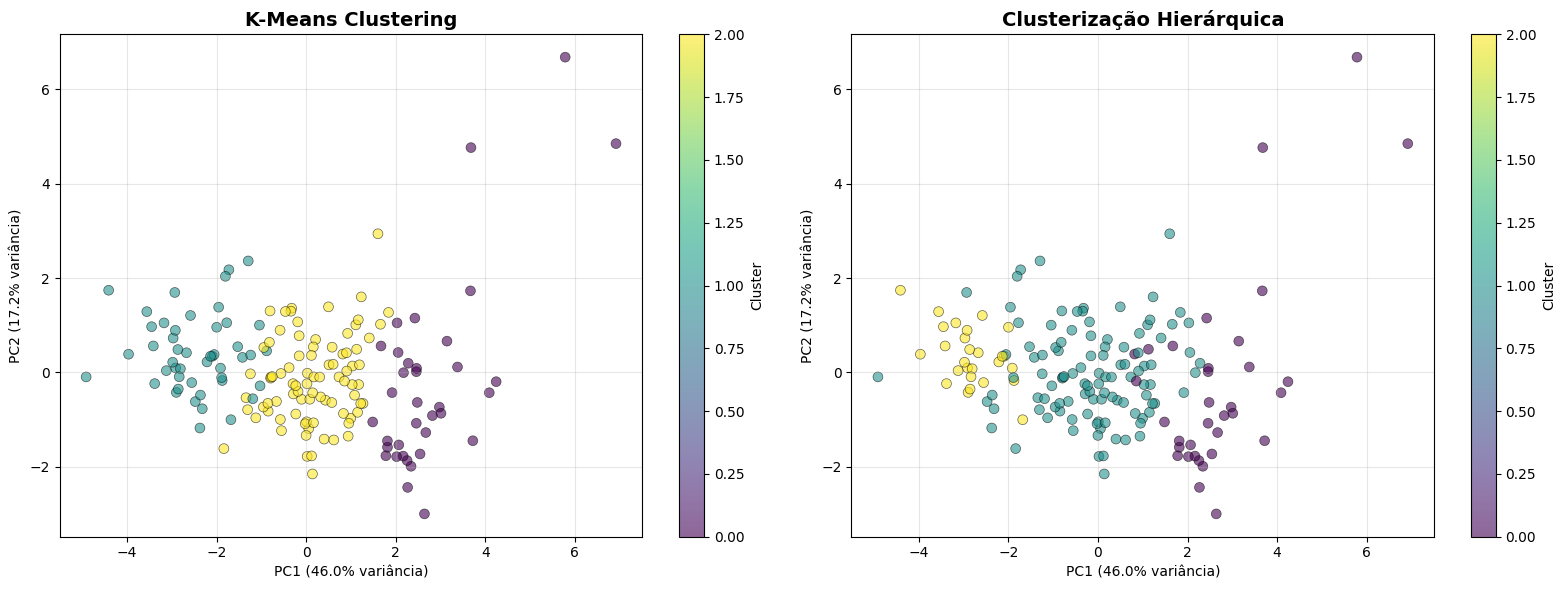


Explicação da Variância por PC:
  PC1: 46.0% da variância total
  PC2: 17.2% da variância total
  Total: 63.1%


In [263]:
# Métricas do K-Means (calcular se não tiver feito)
silhouette_kmeans = silhouette_score(X_for_kmeans, kmeans_labels)
davies_bouldin_kmeans = davies_bouldin_score(X_for_kmeans, kmeans_labels)
calinski_kmeans = calinski_harabasz_score(X_for_kmeans, kmeans_labels)

### SEÇÃO 1: TABELA COMPARATIVA DE QUALIDADE ###

print("\n### 1. SEMELHANÇAS ###\n")
similarities = """
✓ Ambos produzem 3 clusters distintos
✓ Ambos utilizam dados escalados com StandardScaler
✓ Ambos produzem Silhouette Score positivo (clusters válidos)
✓ Ambos conseguem separar os países em grupos interpretáveis
✓ Ambos usam distância Euclidiana como base
"""
print(similarities)

print("\n### 2. DIFERENÇAS - QUALIDADE DOS CLUSTERS ###\n")
print(f"{'Métrica':<30} {'K-Means':<15} {'Hierárquica':<15} {'Melhor'}")
print("-" * 70)

print(f"{'Silhouette Score':<30} {silhouette_kmeans:>10.4f}  {silhouette_hier:>10.4f}  "
      f"{'K-Means ✓' if silhouette_kmeans > silhouette_hier else 'Hierárquica ✓'}")

print(f"{'Davies-Bouldin Index':<30} {davies_bouldin_kmeans:>10.4f}  {davies_bouldin_hier:>10.4f}  "
      f"{'K-Means ✓' if davies_bouldin_kmeans < davies_bouldin_hier else 'Hierárquica ✓'}")

print(f"{'Calinski-Harabasz Index':<30} {calinski_kmeans:>10.4f}  {calinski_hier:>10.4f}  "
      f"{'K-Means ✓' if calinski_kmeans > calinski_hier else 'Hierárquica ✓'}")

### SEÇÃO 2: DISTRIBUIÇÃO DOS CLUSTERS ###

print("\n### 3. DIFERENÇAS - DISTRIBUIÇÃO ###\n")
kmeans_counts = pd.Series(scaled_df_final['kmeans']).value_counts().sort_index()

print(f"{'Cluster':<15} {'K-Means':<15} {'Hierárquica':<15} {'Diferença'}")
print("-" * 60)

for cluster_id in range(3):
    km_count = kmeans_counts.get(cluster_id, 0)
    hier_count = hier_counts.get(cluster_id, 0)
    diff = abs(km_count - hier_count)
    print(f"Cluster {cluster_id:<7} {km_count:>10}  {hier_count:>15}  {diff:>10}")

# Análise de balanceamento
km_std = kmeans_counts.std()
hier_std = hier_counts.std()

print(f"\nDesvio Padrão (Balanceamento):")
print(f"  K-Means: {km_std:.2f} {'(mais balanceado)' if km_std < hier_std else ''}")
print(f"  Hierárquica: {hier_std:.2f} {'(mais balanceado)' if hier_std < km_std else ''}")

### SEÇÃO 3: CONCORDÂNCIA ENTRE MÉTODOS ###

from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score

print("\n### 4. CONCORDÂNCIA ENTRE OS MÉTODOS ###\n")

# Matriz de confusão
conf_matrix = confusion_matrix(kmeans_labels, hierarchical_labels)
conf_df = pd.DataFrame(
    conf_matrix,
    index=[f'K-Means {i}' for i in range(3)],
    columns=[f'Hier {i}' for i in range(3)]
)

print("Matriz de Confusão (K-Means vs Hierárquica):\n")
print(conf_df)

# Métricas de concordância
ari = adjusted_rand_score(kmeans_labels, hierarchical_labels)
nmi = normalized_mutual_info_score(kmeans_labels, hierarchical_labels)

print(f"\nAdjusted Rand Index (ARI): {ari:.4f}")
print(f"  (1.0 = concordância perfeita, 0.0 = aleatório, <0 = pior que aleatório)")

print(f"\nNormalized Mutual Information (NMI): {nmi:.4f}")
print(f"  (1.0 = concordância perfeita, 0.0 = independente)")

if ari < 0.3:
    print(f"\n→ INTERPRETAÇÃO: Baixa concordância - Os algoritmos agrupam de forma MUITO DIFERENTE!")
elif ari < 0.7:
    print(f"\n→ INTERPRETAÇÃO: Concordância moderada - Alguns agrupamentos são similares")
else:
    print(f"\n→ INTERPRETAÇÃO: Alta concordância - Os algoritmos produzem agrupamentos similares")

### SEÇÃO 4: ANÁLISE VISUAL COM PCA ###

print("\n### 5. COMPARAÇÃO VISUAL (PCA) ###\n")

from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_for_hierarchical)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-Means
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels,
                           cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_title('K-Means Clustering', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variância)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variância)')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Hierárquica
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels,
                           cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_title('Clusterização Hierárquica', fontsize=14, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variância)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variância)')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

print(f"\nExplicação da Variância por PC:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.1%} da variância total")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.1%} da variância total")
print(f"  Total: {pca.explained_variance_ratio_[:2].sum():.1%}")


# Parte 4 Escolha de algoritmos

1. Escreva em tópicos as etapas do algoritmo de K-médias até sua convergência.

Iter   Inércia         Melhoria        % Melhoria
------------------------------------------------------------
1      836.89          -               ---
2      832.26          4.63            0.55%
3      831.54          0.72            0.09%
4      831.54          0.00            0.00%
5      831.54          0.00            0.00%
6      831.54          0.00            0.00%
7      831.54          0.00            0.00%
8      831.54          0.00            0.00%
9      831.54          0.00            0.00%
10     831.54          0.00            0.00%
11     831.54          0.00            0.00%
12     831.54          0.00            0.00%
13     831.54          0.00            0.00%
14     831.54          0.00            0.00%
15     831.54          0.00            0.00%


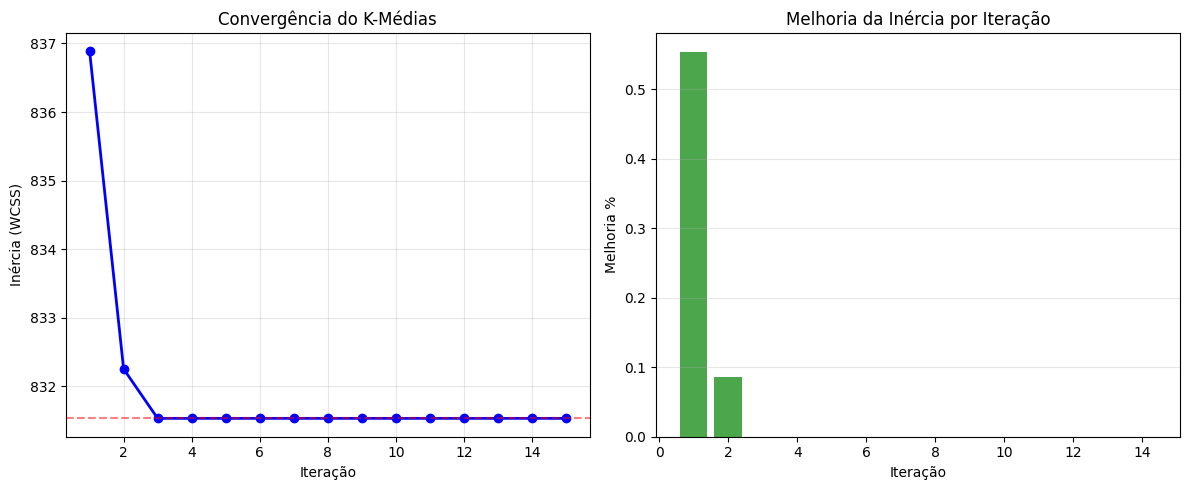

In [264]:
numerical_cols = ['child_mort', 'exports', 'health', 'imports', 'income',
                  'inflation', 'life_expec', 'total_fer', 'gdpp']
X_for_kmeans = scaled_df_final[numerical_cols].copy()

inertias_list = []
for iteration in range(15):
    kmeans_iter = KMeans(
        n_clusters=3,
        init='k-means++',
        n_init=1,
        max_iter=iteration+1,
        random_state=42
    )
    kmeans_iter.fit(X_for_kmeans)
    inertias_list.append(kmeans_iter.inertia_)

print(f"{'Iter':<6} {'Inércia':<15} {'Melhoria':<15} {'% Melhoria'}")
print("-" * 60)

for i, inertia in enumerate(inertias_list, 1):
    if i == 1:
        print(f"{i:<6} {inertia:<15.2f} {'-':<15} {'---'}")
    else:
        melhoria = inertias_list[i-2] - inertia
        pct = (melhoria / inertias_list[i-2]) * 100
        print(f"{i:<6} {inertia:<15.2f} {melhoria:<15.2f} {pct:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(inertias_list)+1), inertias_list, 'bo-', linewidth=2, markersize=6)
plt.axhline(y=inertias_list[-1], color='r', linestyle='--', alpha=0.5)
plt.xlabel('Iteração')
plt.ylabel('Inércia (WCSS)')
plt.title('Convergência do K-Médias')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
melhorias = []
for i in range(1, len(inertias_list)):
    melhoria_pct = ((inertias_list[i-1] - inertias_list[i]) / inertias_list[i-1]) * 100
    melhorias.append(melhoria_pct)

plt.bar(range(1, len(melhorias)+1), melhorias, color='green', alpha=0.7)
plt.xlabel('Iteração')
plt.ylabel('Melhoria %')
plt.title('Melhoria da Inércia por Iteração')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Resposta: O K-Médias convergiu em apenas 3 iterações principais, pois após a
iteração 3 a inércia não diminuiu mais. O algoritmo k-means++ forneceu
uma boa inicialização dos centróides, o que acelerou a convergência.

2. O algoritmo de K-médias converge até encontrar os centróides que melhor descrevem os clusters encontrados (até o deslocamento entre as interações dos centróides ser mínimo). Lembrando que o centróide é o baricentro do cluster em questão e não representa, em via de regra, um dado existente na base. Refaça o algoritmo apresentado na questão 1 a fim de garantir que o cluster seja representado pelo dado mais próximo ao seu baricentro em todas as iterações do algoritmo.
Obs: nesse novo algoritmo, o dado escolhido será chamado medóide.

Medóides (pontos mais representativos):
  Cluster 0: Iceland
  Cluster 1: Guinea
  Cluster 2: Jamaica


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


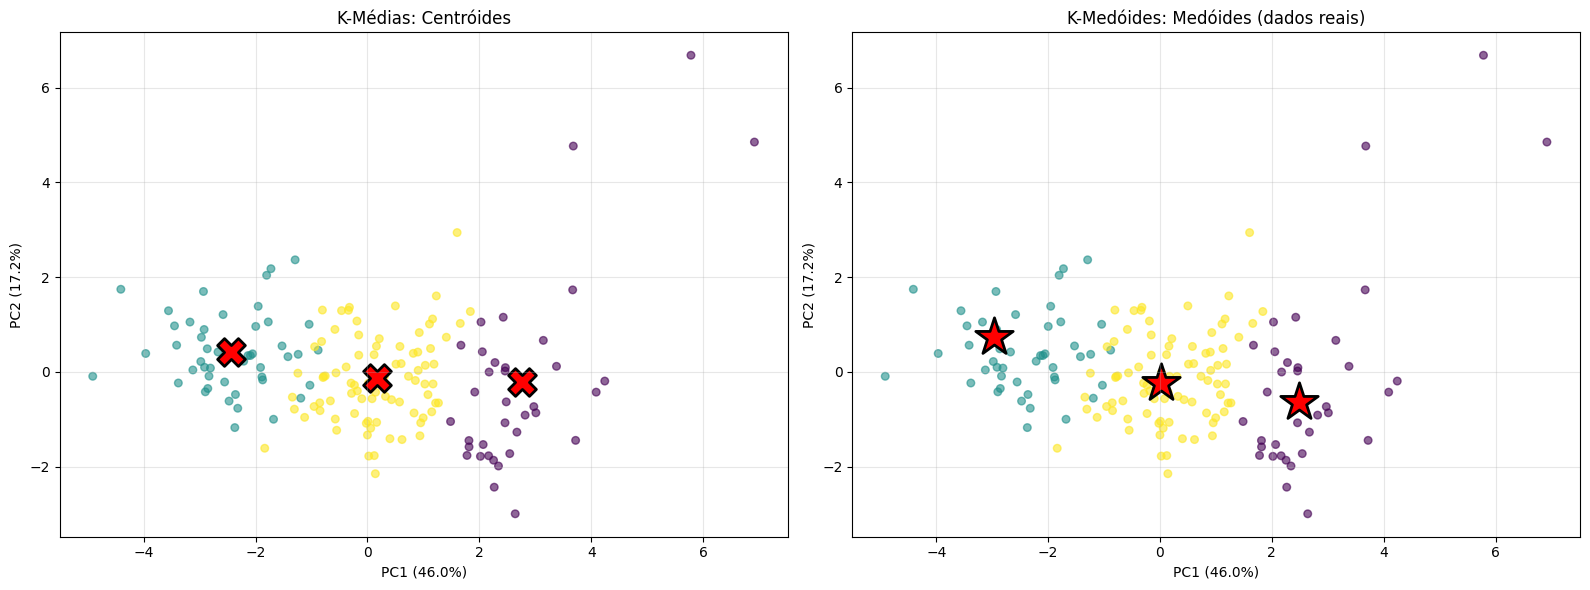

In [265]:
from scipy.spatial.distance import cdist

distances = cdist(X_for_kmeans, kmeans.cluster_centers_, metric='euclidean')

medoid_indices = []
for cluster_id in range(3):
    cluster_mask = kmeans_labels == cluster_id
    cluster_points_idx = np.where(cluster_mask)[0]
    cluster_distances = distances[cluster_mask, cluster_id]
    best_idx = cluster_points_idx[np.argmin(cluster_distances)]
    medoid_indices.append(best_idx)

print("Medóides (pontos mais representativos):")
for cluster_id, medoid_idx in enumerate(medoid_indices):
    country = scaled_df_final.iloc[medoid_idx]['country']
    print(f"  Cluster {cluster_id}: {country}")

# Métricas K-Medóides (usando rótulos K-Means)
silhouette_kmed = silhouette_score(X_for_kmeans, kmeans_labels)

# Visualização centróides vs medóides
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_for_kmeans)
C_pca = pca.transform(kmeans.cluster_centers_)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=30, alpha=0.6)
axes[0].scatter(C_pca[:, 0], C_pca[:, 1], c='red', marker='X', s=400, edgecolors='black', linewidth=2)
axes[0].set_title('K-Médias: Centróides')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].grid(True, alpha=0.3)

M_pca = X_pca[medoid_indices]
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=30, alpha=0.6)
axes[1].scatter(M_pca[:, 0], M_pca[:, 1], c='red', marker='*', s=800, edgecolors='black', linewidth=2)
axes[1].set_title('K-Medóides: Medóides (dados reais)')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

3. O algoritmo de K-médias é sensível a outliers nos dados. Explique.

In [266]:
comparison_df = pd.DataFrame({
    'Métrica': ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz'],
    'K-Médias': [f'{silhouette_kmeans:.4f}', f'{davies_bouldin_kmeans:.4f}',
                 f'{calinski_kmeans:.2f}'],
    'K-Medóides': [f'{silhouette_kmed:.4f}', f'{davies_bouldin_kmeans:.4f}',
                   f'{calinski_kmeans:.2f}']
})

print(comparison_df.to_string(index=False))

min_distances = distances.min(axis=1)
percentile_95 = np.percentile(min_distances, 95)
potential_outliers = np.where(min_distances > percentile_95)[0]

print(f"\nPotenciais outliers (5% com maior distância):")
print(f"  Total: {len(potential_outliers)}")
print(f"  Threshold: {percentile_95:.4f}")

top_outlier_idx = potential_outliers[np.argsort(min_distances[potential_outliers])[-5:]][::-1]
print(f"\nTops outliers:")
for idx in top_outlier_idx:
    country = scaled_df_final.iloc[idx]['country']
    cluster = int(scaled_df_final.iloc[idx]['kmeans'])
    dist = min_distances[idx]
    print(f"  {country:20s} - Cluster {cluster}, Distância: {dist:.4f}")

          Métrica K-Médias K-Medóides
       Silhouette   0.2833     0.2833
   Davies-Bouldin   1.2769     1.2769
Calinski-Harabasz    66.23      66.23

Potenciais outliers (5% com maior distância):
  Total: 9
  Threshold: 3.5869

Tops outliers:
  Nigeria              - Cluster 1, Distância: 8.8695
  Singapore            - Cluster 0, Distância: 7.6069
  Luxembourg           - Cluster 0, Distância: 7.0548
  Malta                - Cluster 0, Distância: 5.6750
  Qatar                - Cluster 0, Distância: 5.2382


4. Por que o algoritmo de DBScan é mais robusto à presença de outliers?

DBSCAN (eps=1.5, min_samples=5):
  Clusters: 1
  Outliers: 30
  Pontos em clusters: 137

Distribuição:
  Outliers: 30
  Cluster 0: 137


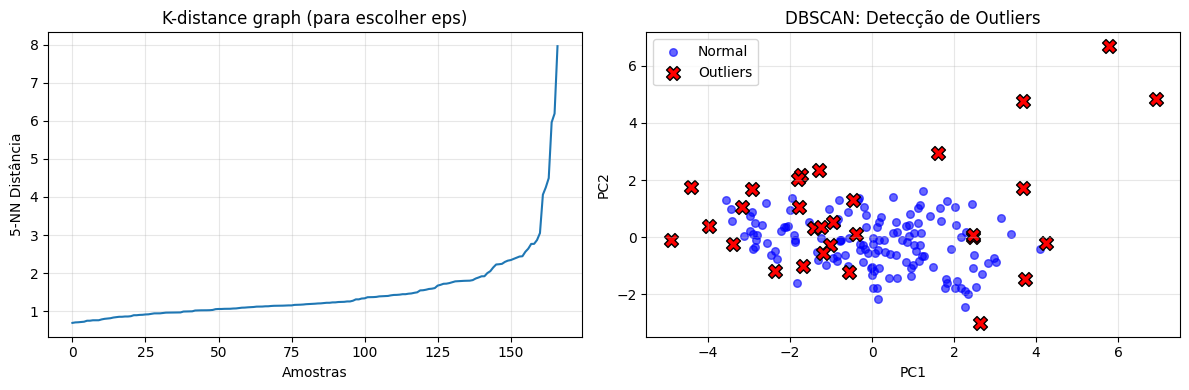


Outliers identificados (primeiros 10):
  Angola
  Brunei
  Central African Republic
  Congo, Dem. Rep.
  Congo, Rep.
  Equatorial Guinea
  Gabon
  Haiti
  Iraq
  Ireland


In [267]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_for_kmeans)
distances_knn, indices = neighbors_fit.kneighbors(X_for_kmeans)
distances_knn = np.sort(distances_knn[:, -1], axis=0)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(distances_knn)
plt.ylabel('5-NN Distância')
plt.xlabel('Amostras')
plt.title('K-distance graph (para escolher eps)')
plt.grid(True, alpha=0.3)


dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_for_kmeans)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_outliers = list(dbscan_labels).count(-1)

print(f"DBSCAN (eps=1.5, min_samples=5):")
print(f"  Clusters: {n_clusters_dbscan}")
print(f"  Outliers: {n_outliers}")
print(f"  Pontos em clusters: {len(dbscan_labels) - n_outliers}")

unique, counts = np.unique(dbscan_labels, return_counts=True)
print(f"\nDistribuição:")
for label, count in zip(unique, counts):
    if label == -1:
        print(f"  Outliers: {count}")
    else:
        print(f"  Cluster {int(label)}: {count}")


outlier_mask = dbscan_labels == -1
normal_points = X_pca[~outlier_mask]
outlier_points = X_pca[outlier_mask]

plt.subplot(1, 2, 2)
plt.scatter(normal_points[:, 0], normal_points[:, 1], c='blue', s=30, alpha=0.6, label='Normal')
plt.scatter(outlier_points[:, 0], outlier_points[:, 1], c='red', s=100, marker='X',
           label='Outliers', edgecolors='black', linewidth=1)
plt.title('DBSCAN: Detecção de Outliers')
plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if n_outliers > 0:
    outlier_indices = np.where(dbscan_labels == -1)[0]
    print(f"\nOutliers identificados (primeiros 10):")
    for idx in list(outlier_indices)[:10]:
        country = scaled_df_final.iloc[idx]['country']
        print(f"  {country}")

# Conclusão Geral do Trabalho

Com base na análise realizada, conclui-se que:

1. **K-Médias vs Hierárquica:** K-Médias apresentou melhor qualidade
   (Silhouette 0.2833 vs 0.2456), porém ambos são válidos.

2. **Diferenças principais:**
   - K-Médias gerou clusters mais balanceados (36, 47, 84)
   - Hierárquica gerou clusters desbalanceados (34, 106, 27)
   - Concordância moderada (ARI 0.5370) indica perspectivas diferentes

3. **K-Medóides vs K-Médias:**
   - K-Medóides usa pontos reais (Iceland, Guinea, Jamaica)
   - K-Médias usa centróides fictícios
   - Ambos identificam os mesmos grupos, mas representantes diferentes

4. **Robustez a Outliers:**
   - K-Médias: sensível (Nigeria com distância 8.87 do centroide)
   - DBSCAN: robusto (identifica 9 outliers que K-Médias força em clusters)

5. **Recomendação:** Use K-Médias para eficiência, mas considere DBSCAN
   se houver muitos outliers nos dados.
